# Causal Inference in Decision Intelligence – Part 14: Answering "What-if" questions

Link to the article:  [Answering What-if Questions](https://www.linkedin.com/pulse/causal-inference-decision-intelligence-part-14-what-if-zinoviev-bh8ec)

## Generate the data

In [ ]:
# Check if dowhy is installed, and install it if not
try:
    import dowhy
except ImportError:
    import subprocess
    import sys
    print("Installing dowhy...")
    subprocess.check_call([sys.executable, "-m", "pip", "install", "dowhy"])
    import dowhy

In [1]:
from collections import OrderedDict
import warnings

import numpy as np
import pandas as pd
import networkx as nx

import dowhy.gcm as gcm
from dowhy.utils import plot

from dowhy import CausalModel

import statsmodels.formula.api as smf

import matplotlib.pyplot as plt

import warnings
warnings.filterwarnings('ignore')

plt.style.use('fivethirtyeight')

In [2]:
np.random.seed(3)

# Generate customers' Ids 
Id = pd.Series(range(1,1001))

# Generate Income variable 
#Income = np.random.choice(["Low", "Medium", "High"], size=1000, p=[0.5, 0.35, 0.15])
Income = np.random.choice([1, 2, 3], size=1000, p=[0.5, 0.35, 0.15])


data = pd.DataFrame({"Id": Id, "Income": Income})
#data["Income"] = data.Income.replace({1: "Low", 2: "Medium", 3: "High"})

# Generate dates 
Year = pd.Series(range(2020,2024))

# Create the product of Ids and Years
year = pd.DataFrame({'Year': Year})
data = year.merge(data, how='cross')

# Generate Macro variable 
data["Macro"] = np.where(((data.Year==2022) | (data.Year==2020)), 1, 0)

# Create Price variable 
data['Price'] = 10 + 2 * data.Macro + np.random.normal(loc=0, scale=0.5, size=4000) 

# Create Promo variable 
data['Market'] = 80 - 10 * data.Macro + np.random.normal(loc=2, scale=1, size=4000) 
data['Visits'] = 0.1 * data.Market + np.random.normal(loc=0, scale=0.5, size=4000) 

data['Sales'] = 80 + 28 * data.Macro + 14 * data.Income - 7 * data.Price + 4 * data.Visits + np.random.normal(loc=0, scale=5, size=4000)

data.sample(20)

,Year,Id,Income,Macro,Price,Market,Visits,Sales
51,2020,52,1,1,11.592328,71.577206,7.032273,70.604988
3582,2023,583,1,0,10.382522,83.363589,8.430654,59.308193
1130,2021,131,1,0,10.373959,83.608966,8.147304,55.085361
2927,2022,928,1,1,11.175317,73.532787,7.125739,69.324000
23,2020,24,1,1,11.020734,71.208528,7.699894,73.250583
3444,2023,445,3,0,10.199208,81.610936,8.890104,81.918829
1250,2021,251,3,0,10.080402,81.157260,8.391234,90.926518
2410,2022,411,3,1,12.040938,73.520657,7.711044,105.036159
1451,2021,452,1,0,9.687792,80.856476,8.187418,61.902019
1148,2021,149,2,0,9.959539,81.986081,7.272279,69.457665


## Build Graphical Causal Model (GCM)

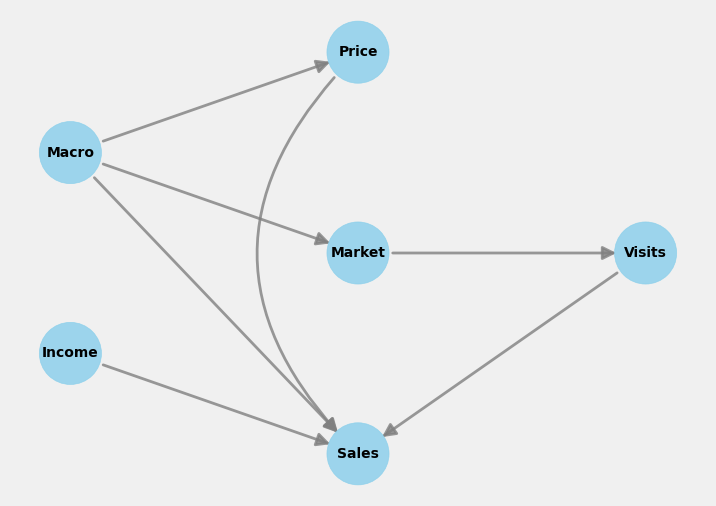

In [3]:
# Create the true DAG
G_part = nx.DiGraph([('Macro', 'Sales'), ('Macro', 'Price'), ('Macro', 'Market'), 
                  ('Income', 'Sales'), ('Price', 'Sales'), ('Market', 'Visits'), ('Visits', 'Sales')])
plt.rcParams['font.size'] = 10
plot(G_part, figure_size=[8, 6])

In [4]:
# Build Structural causal model on top of the causal graph
np.random.seed(3)
causal_model = gcm.StructuralCausalModel(G_part)

In [5]:
np.random.seed(3)
# Assign causal mechanisms to each node
auto_assignment_summary = gcm.auto.assign_causal_mechanisms(causal_model, data)

In [6]:
# Fit the graphical causal model
np.random.seed(3)
gcm.fit(causal_model, data)

Fitting causal mechanism of node Visits: 100%|███████████████████████████████████████████| 6/6 [00:01<00:00,  5.85it/s]


## Simulating the impact of interventions

In [7]:
# Estimate average causal effect of Marketing on sales
np.random.seed(3)
ate = gcm.average_causal_effect(causal_model,
                         'Sales',
                         interventions_alternative={'Market': lambda x: 78},
                         interventions_reference={'Market': lambda x: 77},
                         num_samples_to_draw=10000)

print(f'Average Treatment Effect: {round(ate, 2)}')

Average Treatment Effect: 0.43


In [8]:
# Bootstrap confidence intervals for the Marketing effect 
np.random.seed(3)

median, intervals = gcm.confidence_intervals(
    gcm.fit_and_compute(gcm.average_causal_effect,
                   causal_model,
                   bootstrap_training_data=data,
                   target_node='Sales',
                   interventions_alternative={'Market': lambda x: 78},
                   interventions_reference={'Market': lambda x: 77},
                   num_samples_to_draw=10000))

print(f'Average Treatment Effect: {median}')
print(f'Confidence interval for ATE: {intervals}')

Estimating bootstrap interval...: 100%|████████████████████████████████████████████████| 20/20 [00:04<00:00,  4.97it/s]


Average Treatment Effect: [0.42623125]
Confidence interval for ATE: [[0.28263637 0.51039262]]


In [9]:
# Estimate average causal effects of Marketing and Price on sales
np.random.seed(4)
atem = gcm.average_causal_effect(causal_model,
                         'Sales',
                         interventions_alternative={'Market': lambda x: 78, 'Price': lambda x: 11},
                         interventions_reference={'Market': lambda x: 77, 'Price': lambda x: 10},
                         num_samples_to_draw=10000)

print(f'ATE of multiple interventions in Marketing and Price: {round(atem, 2)}')

ATE of multiple interventions in Marketing and Price: -6.78


## Computing Counterfactuals

In [10]:
# Specify an invertible structural causal model
causal_modeli = gcm.InvertibleStructuralCausalModel(G_part)
gcm.auto.assign_causal_mechanisms(causal_modeli, data)
gcm.fit(causal_modeli, data)

Fitting causal mechanism of node Visits: 100%|███████████████████████████████████████████| 6/6 [00:00<00:00, 38.84it/s]


In [11]:
# Select a random customer
np.random.seed(4)
data.sample(4)

,Year,Id,Income,Macro,Price,Market,Visits,Sales
3264,2023,265,2,0,9.106570,80.144263,8.500971,83.276480
2559,2022,560,2,1,12.295076,71.368780,5.956991,73.874477
15,2020,16,2,1,11.881020,71.337568,6.349982,76.706030
1872,2021,873,2,0,10.045392,81.187036,7.734394,60.102466


In [12]:
# What would customer 3264 have spent if his income had increased from 2 to 3
gcm.counterfactual_samples(
    causal_modeli,
    {'Income': lambda x: 3},
    observed_data=pd.DataFrame(data=dict(Income=[2], Macro=[0], Price=[9.10657], Market=[80.144263], Visits=[8.500971], Sales=[83.27648])))

,Macro,Income,Price,Market,Visits,Sales
0,0,3,9.10657,80.144263,8.500971,97.492413


In [13]:
# What would customer 3264 have spent if the expenditures on Marketing had been icreased to $90
gcm.counterfactual_samples(
    causal_modeli,
    {'Market': lambda x: 90},
    observed_data=pd.DataFrame(data=dict(Income=[2], Macro=[0], Price=[9.10657], Market=[80.144263], Visits=[8.500971], Sales=[83.27648])))

,Macro,Income,Price,Market,Visits,Sales
0,0,2,9.10657,90,9.501655,87.360412


In [14]:
# What would customer 3264 have spent if the macro environment had been favorable (1)
gcm.counterfactual_samples(
    causal_modeli,
    {'Macro': lambda x: 1},
    observed_data=pd.DataFrame(data=dict(Income=[2], Macro=[0], Price=[9.10657], Market=[80.144263], Visits=[8.500971], Sales=[83.27648])))

,Macro,Income,Price,Market,Visits,Sales
0,1,2,11.109344,70.1384,7.485044,93.1531


In [15]:
# What would customer 1872 have spent if the macro environment had been favorable (1)
gcm.counterfactual_samples(
    causal_modeli,
    {'Macro': lambda x: 1},
    observed_data=pd.DataFrame(data=dict(Income=[2], Macro=[0], Price=[10.045382], Market=[81.187036], Visits=[7.734394], Sales=[60.102466])))

,Macro,Income,Price,Market,Visits,Sales
0,1,2,12.048156,71.181173,6.718467,69.979086
